In [2]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torchvision.transforms as transforms

os.chdir(os.path.join(os.getcwd(), '..'))

from data import PollenDataset

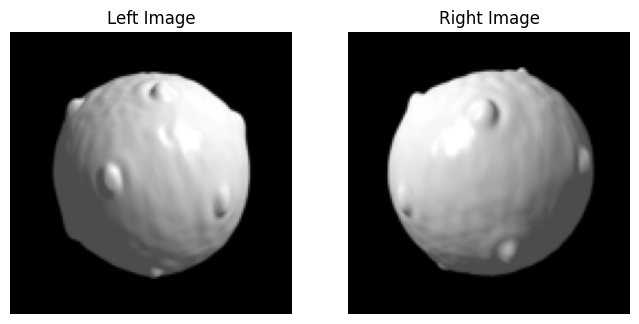

In [3]:
image_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

dataset = PollenDataset(image_transforms=image_transforms)

(left_img, right_img), points, rotation, name = dataset[0]

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(left_img.permute(1,2,0), cmap='gray')
plt.title("Left Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(right_img.permute(1,2,0), cmap='gray')
plt.title("Right Image")
plt.axis("off")
plt.show()

In [4]:
(sample_images, points, rotation, name) = dataset[0]
front_tensor, side_tensor = sample_images  # Assume left = front view, right = side view

In [5]:
name

'C:/Users/fahrn/Documents/Classes/bat/sequoia/data\\processed\\meshes\\17767_Common_knapweed_Centaurea_nigra_pollen_grain.stl'

In [6]:
# Convert tensors to numpy arrays (images are 1024x1024)
front_np = front_tensor.squeeze(0).numpy()
side_np = side_tensor.squeeze(0).numpy()

# Create binary masks: any nonzero pixel is considered part of the object.
front_bin = (front_np > 0).astype(np.uint8)
side_bin = (side_np > 0).astype(np.uint8)

# Define the volume dimensions (cubic volume, size from image dimensions)
H, W = front_bin.shape  # (1024, 1024)
D = W  # depth = width, i.e., 1024

# Extrude the front silhouette along the z-axis.
front_vol = np.repeat(front_bin[:, :, np.newaxis], D, axis=2)

# Extrude the side silhouette along the x-axis.
# The side view corresponds to (z, y); insert an axis for x and repeat.
side_vol = np.repeat(side_bin[:, np.newaxis, :], W, axis=1)

# Compute the visual hull as the voxel-wise intersection.
visual_hull = np.logical_and(front_vol, side_vol)

# Downsample the volume for faster visualization if necessary.
# For instance, reduce by a factor of 8 (adjust step as needed).
step = 1
voxel_data = visual_hull[::step, ::step, ::step]

### 1. Load sample data and compute the reconstruction (visual hull)

In [7]:
front_bin = (front_np > 0).astype(np.uint8)
side_bin = (side_np > 0).astype(np.uint8)

# Define volume dimensions – we assume a cubic volume.
H, W = front_bin.shape  # should be 1024 x 1024
D = W  # depth equal to width

# Extrude the front silhouette along the z-axis:
front_vol = np.repeat(front_bin[:, :, np.newaxis], D, axis=2)

# Extrude the side silhouette along the x-axis:
side_vol = np.repeat(side_bin[:, np.newaxis, :], W, axis=1)

# Compute the voxel-wise intersection (Visual Hull):
recon_volume = np.logical_and(front_vol, side_vol)
print("Reconstruction voxel volume shape:", recon_volume.shape)


Reconstruction voxel volume shape: (128, 128, 128)


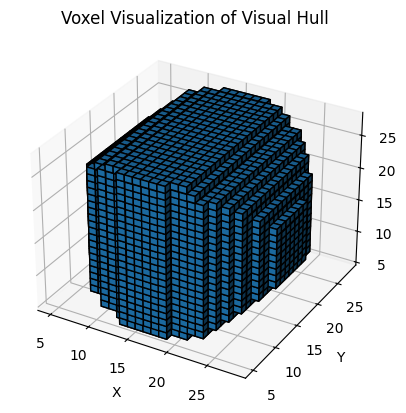

In [8]:
# simplify the voxels
step = 4
simplified_recon_volume = recon_volume[::step, ::step, ::step]

ax = plt.figure().add_subplot(projection='3d')
ax.voxels(simplified_recon_volume, edgecolor='k')
ax.set_title("Voxel Visualization of Visual Hull")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()

In [11]:
from scipy.ndimage import rotate

def iou3d(vol1, vol2):
    intersection = np.logical_and(vol1, vol2)
    union = np.logical_or(vol1, vol2)
    return np.sum(intersection) / np.sum(union)

def rotate_voxel_grid(voxel_grid, angle_x=0, angle_y=0, angle_z=0):
    """
    Rotate a 3D voxel occupancy grid about the x, y, and z axes.
    
    Parameters:
    - voxel_grid: 3D numpy array of booleans where True indicates an occupied voxel.
    - angle_x: Rotation angle (in degrees) around the x-axis (applied in the (y, z) plane).
    - angle_y: Rotation angle (in degrees) around the y-axis (applied in the (x, z) plane).
    - angle_z: Rotation angle (in degrees) around the z-axis (applied in the (x, y) plane).
    
    Returns:
    - A new 3D numpy array representing the rotated voxel grid.
    """
    # Rotate around the x-axis (rotate in the (y, z) plane)
    rotated = rotate(voxel_grid, angle=angle_x, axes=(1, 2),
                     reshape=True, order=0, mode='constant', cval=False)
    # Rotate around the y-axis (rotate in the (x, z) plane)
    rotated = rotate(rotated, angle=angle_y, axes=(0, 2),
                     reshape=True, order=0, mode='constant', cval=False)
    # Rotate around the z-axis (rotate in the (x, y) plane)
    rotated = rotate(rotated, angle=angle_z, axes=(0, 1),
                     reshape=True, order=0, mode='constant', cval=False)
    
    return rotated

recon_volume_rotated = rotate_voxel_grid(recon_volume, -rotation[0], -rotation[1], -rotation[2])

TODO: Normalized Surface Distance?

In [12]:
# models/visual_hull.py
import torch
import numpy as np
import lightning.pytorch as pl

class VisualHull(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.dummy_param = torch.nn.Parameter(torch.zeros(1))
        
    def forward(self, front_tensor: torch.Tensor, side_tensor: torch.Tensor, step: int = 1) -> np.ndarray:
        front_np = front_tensor.squeeze().detach().cpu().numpy()
        side_np = side_tensor.squeeze().detach().cpu().numpy()
    
        front_bin = (front_np > 0).astype(np.uint8)
        side_bin = (side_np > 0).astype(np.uint8)
        
        print(front_bin.shape)
        
        H, W = front_bin.shape
        D = W

        front_vol = np.repeat(front_bin[:, :, np.newaxis], D, axis=2)
        side_vol = np.repeat(side_bin[:, np.newaxis, :], W, axis=1)
        visual_hull = np.logical_and(front_vol, side_vol)
        voxel_data = visual_hull[::step, ::step, ::step]
        
        return voxel_data

    def training_step(self, batch, batch_idx):
        (left_image, right_image), _, rotations, _ = batch
        _ = self.forward(left_image, right_image)
        loss = self.dummy_param * 0.0
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        (left_image, right_image), _, rotations, _ = batch
        voxel_data = self.forward(left_image, right_image)
        # For instance, log the voxel count as an evaluation metric.
        voxel_count = float(voxel_data.sum())
        self.log("val_voxel_count", voxel_count, prog_bar=True)
        loss = self.dummy_param * 0.0
        self.log("val_loss", loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)


In [13]:
vh = VisualHull()

(left, right), points, rotation, name = dataset[0]

vh(left.unsqueeze(0), right.unsqueeze(0))

(128, 128)


array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, Fal

In [14]:
import trimesh

mesh = trimesh.load(os.path.join('data', 'processed', 'meshes', name))

In [15]:
voxel = mesh.voxelized(pitch=1)

In [16]:
voxel.show()

c:\Users\fahrn\Documents\Classes\bat\sequoia\.venv\Lib\site-packages\pyglet\libs\win32\__init__.py:318: UserWarning: Could not set COM MTA mode. Unexpected behavior may occur.
  warnings.warn("Could not set COM MTA mode. Unexpected behavior may occur.")


In [17]:
largest_shape = (0,0,0)
name = None

for idx in range(len(dataset)):
    _, _, _, name = dataset[idx]

    mesh = trimesh.load(os.path.join('data', 'processed', 'meshes', name))
    
    vox = mesh.voxelized(pitch=1.0)

    if vox.matrix.shape > largest_shape:
        largest_shape = vox.matrix.shape
        name = name

print(largest_shape)

(191, 143, 47)


### Define one canonical 3‑D box and its voxel pitch


| symbol |                  meaning                 |                                                         how to choose it                                                         |
|:------:|:----------------------------------------:|:--------------------------------------------------------------------------------------------------------------------------------:|
| B      | 3‑D axis‑aligned bounding cube ($\R^3$)      | the volume you handed to the visual‑hull algorithm (e.g. [-0.5,+0.5]³ or the intersection of the two orthographic camera frusta)|
| N      | grid resolution                          | 128 in your case                                                                                                                 |
| p      | voxel pitch (edge length in world units) | p = (max_edge_length(B) / N)                                                                                                     |

In [ ]:
x_world = B.min + (i + 0.5, j + 0.5, k + 0.5) * p

In [18]:
print(name)
mesh = trimesh.load(os.path.join('data', 'processed', 'meshes', name))

C:/Users/fahrn/Documents/Classes/bat/sequoia/data\processed\meshes\21628_Cowslip_Primula_veris_pollen_grain_shrunken.stl


In [ ]:
import trimesh
N = 128

# 1. Shift to origin
mesh.apply_translation(-mesh.bounds.mean(axis=0))

# 2. Uniformly scale so the longest edge fits in the cube
bbox_size = (mesh.bounds[1] - mesh.bounds[0]).max()
s = (N - 1e-5) / bbox_size          # tiny epsilon so we never spill over
mesh.apply_scale(s)

# 3. Optional: rotate so that +X faces camera‑front, +Z camera‑side
#    (this depends on your dataset’s convention)
#mesh.apply_transform(my_rotation_4x4)

# 4. Finally voxelise *exactly* on the (0…N‑1)³ lattice
vox_gt = mesh.voxelized(pitch=1).dense.astype(bool)   # trimesh ≥4.0  :contentReference[oaicite:0]{index=0}
